# Multi-Class Classification

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/AugmentedGPLikelihoods.jl/blob/main/examples/categorical/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/AugmentedGPLikelihoods.jl/dev/examples/categorical/).*

We load all the necessary packages

In [1]:
using AbstractGPs
using ApproximateGPs
using ArraysOfArrays
using AugmentedGPLikelihoods
using Distributions
using LinearAlgebra
using SplitApplyCombine

Plotting libraries

In [2]:
using Plots

We create some random data (sorted for plotting reasons)

In [3]:
N = 100
Nclass = 3
x = collect(range(-10, 10; length=N));

We will present simultaneously the bijective and non-bijective likelihood

In [4]:
liks = [
    CategoricalLikelihood(BijectiveSimplexLink(LogisticSoftMaxLink(Nclass))),
    CategoricalLikelihood(LogisticSoftMaxLink(Nclass)),
];

This is small hack until https://github.com/JuliaGaussianProcesses/GPLikelihoods.jl/pull/68 is merged

In [5]:
AugmentedGPLikelihoods.nlatent(::CategoricalLikelihood{<:BijectiveSimplexLink}) = Nclass - 1
AugmentedGPLikelihoods.nlatent(::CategoricalLikelihood{<:LogisticSoftMaxLink}) = Nclass

SplitApplyCombine.invert(x::ArrayOfSimilarArrays) = nestedview(flatview(x)')

We define the models

In [6]:
kernel = 5.0 * with_lengthscale(SqExponentialKernel(), 2.0)
gp = GP(kernel)
fz = gp(x, 1e-8);

We use a multi-output GP to generate our (N-1) latent GPs

In [7]:
gpm = GP(IndependentMOKernel(kernel))
X = MOInput(x, Nclass - 1);

We sample (N-1) latent GPs to force the setting of the bijective version
which the non-bijective version should also be able to recover

In [8]:
fs = rand(gpm(X, 1e-6))
fs = nestedview(reduce(hcat, Iterators.partition(fs, N)))
lik_true = liks[1](invert(fs)) # the likelihood
y = rand(lik_true);

We build the one-hot encoding for each likelihood (different)

In [9]:
Ys = map(liks) do lik
    Y = nestedview(sort(unique(y))[1:nlatent(lik)] .== permutedims(y))
    return Y
end;

We plot the sampled data

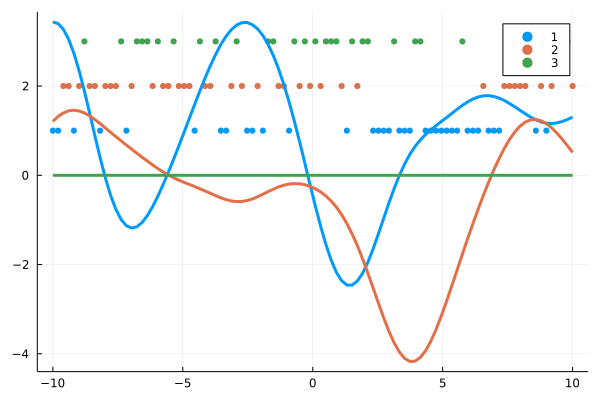

In [10]:
plts = map(["Bijective Logistic-softmax", "Logistic-softmax"]) do title
    plt = plot(; title)
    scatter!(plt, x, y; group=y, label=[1 2 3 4], msw=0.0)
    plot!(plt, x, vcat(fs, [zeros(N)]); color=[1 2 3 4], label="", lw=3.0)
end
plot(plts[1]; title="")

## CAVI Updates
We write our CAVI algorithmm

In [11]:
function u_posterior(fz, m, S)
    return posterior(SparseVariationalApproximation(Centered(), fz, MvNormal(copy(m), S)))
end

function cavi!(fz::AbstractGPs.FiniteGP, lik, x, Y, ms, Ss, qΩ; niter=10)
    K = ApproximateGPs._chol_cov(fz)
    for _ in 1:niter
        posts_u = u_posterior.(Ref(fz), ms, Ss)
        posts_fs = marginals.([p_u(x) for p_u in posts_u])
        aux_posterior!(qΩ, lik, Y, SplitApplyCombine.invert(posts_fs))
        Ss .=
            inv.(
                Symmetric.(Ref(inv(K)) .+ Diagonal.(expected_auglik_precision(lik, qΩ, Y)))
            )
        ms .= Ss .* (expected_auglik_potential(lik, qΩ, Y) .- Ref(K \ mean(fz)))
    end
    return ms, Ss
end

cavi! (generic function with 1 method)

Now we just initialize the variational parameters and run CAVI

In [12]:
ms_Ss = map(liks, Ys) do lik, Y
    m = nestedview(zeros(N, nlatent(lik)))
    S = [Matrix{Float64}(I(N)) for _ in 1:nlatent(lik)]
    qΩ = init_aux_posterior(lik, N)
    fz = gp(x, 1e-8)
    cavi!(fz, lik, x, Y, m, S, qΩ; niter=20)
    return (; m, S)
end

2-element Vector{NamedTuple{(:m, :S), Tuple{ArraysOfArrays.ArrayOfSimilarArrays{Float64, 1, 1, 2, Matrix{Float64}}, Vector{Matrix{Float64}}}}}:
 (m = [[1.079756166328496, 1.0136087574910828, 0.9253755562450479, 0.8152063292900988, 0.6838113040830339, 0.5324832837954409, 0.36310988366613833, 0.17817500953164817, -0.01925195516938601, -0.22554180999524318  …  0.3035624561128487, 0.11473022166397706, -0.0636088706535064, -0.2294057690340241, -0.38084471436825773, -0.516381234834896, -0.6347773018366375, -0.7351322912511578, -0.8169075768725453, -0.8799428261149924], [1.4034057053443059, 1.5003998629031108, 1.5893295464808526, 1.6685257227324615, 1.7366564815980607, 1.7927987689450533, 1.8364871179905828, 1.8677346913028792, 1.8870238459682922, 1.895266042350259  …  1.6116064685359592, 1.693568742334559, 1.7388230773693643, 1.749932249253612, 1.7302631571327567, 1.683783120433897, 1.6148456405799707, 1.5279787489145742, 1.4276876118376125, 1.3182811777269874]], S = [[1.0689420535512684 0.9

And visualize the obtained variational posterior

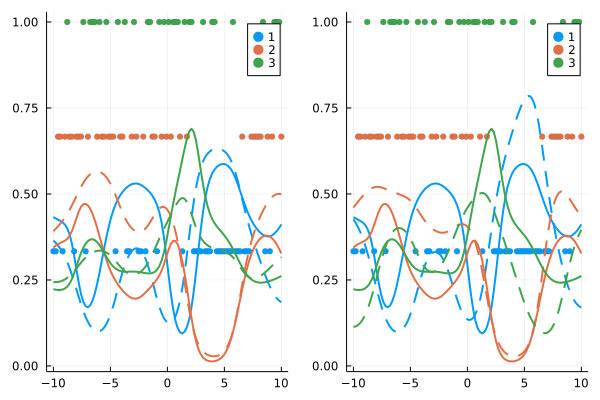

In [13]:
x_te = -10:0.01:10
for i in 1:2
    for j in 1:nlatent(liks[i])
        plot!(
            plts[i],
            x_te,
            u_posterior(fz, ms_Ss[i].m[j], ms_Ss[i].S[j]);
            color=j,
            alpha=0.3,
            lw=3.0,
            label="",
        )
    end
end
plot(plts...)

p_plts = [plot() for _ in 1:2]
for i in 1:2
    scatter!(p_plts[i], x, y / Nclass; group=y, label=[1 2 3 4], msw=0.0)

    # vline!(p_plts[i], x, group=fs_ys[i].y, lw=20/length(x) * 20.0, alpha=0.2, ylims=(0,1),title="p(y=k|f)", label="")
    lik_pred =
        liks[i].(
            invert(
                mean.([
                    u_post(x_te) for u_post in u_posterior.(Ref(fz), ms_Ss[i].m, ms_Ss[i].S)
                ]),
            ),
        )
    ps = getproperty.(lik_pred, :p)
    lik_pred_x =
        liks[i].(
            invert(
                mean.([
                    u_post(x) for u_post in u_posterior.(Ref(fz), ms_Ss[i].m, ms_Ss[i].S)
                ]),
            ),
        )
    ps_x = getproperty.(lik_pred_x, :p)
    ps_true = getproperty.(lik_true.v, :p)
    for k in 1:Nclass
        plot!(p_plts[i], x, invert(ps_true)[k]; color=k, lw=2.0, label="")
        plot!(p_plts[i], x_te, invert(ps)[k]; color=k, lw=2.0, label="", ls=:dash)
    end
end
plot(p_plts...)

## ELBO
How can one compute the Augmented ELBO?
Again AugmentedGPLikelihoods provides helper functions
to not have to compute everything yourself

In [14]:
function aug_elbo(lik, u_post, x, y)
    qf = marginals(u_post(x))
    qΩ = aux_posterior(lik, y, qf)
    return expected_logtilt(lik, qΩ, y, qf) - aux_kldivergence(lik, qΩ, y) -
           kldivergence(u_post.approx.q, u_post.approx.fz)
end

aug_elbo (generic function with 1 method)

aug_elbo(lik, u_posterior(fz, m, S), x, y)
## Gibbs Sampling
We create our Gibbs sampling algorithm (we could do something fancier with
AbstractMCMC)

In [15]:
function gibbs_sample(fz, lik, Y, fs, Ω; nsamples=200)
    K = ApproximateGPs._chol_cov(fz)
    Σ = [zeros(N, N) for _ in 1:nlatent(lik)]
    μ = [zeros(N) for _ in 1:nlatent(lik)]
    return map(1:nsamples) do _
        aux_sample!(Ω, lik, Y, invert(fs))
        Σ .= inv.(Symmetric.(Ref(inv(K)) .+ Diagonal.(auglik_precision(lik, Ω, Y))))
        μ .= Σ .* (auglik_potential(lik, Ω, Y) .- Ref(K \ mean(fz)))
        rand!.(MvNormal.(μ, Σ), fs)
        return copy(fs)
    end
end;

We initialize our random variables

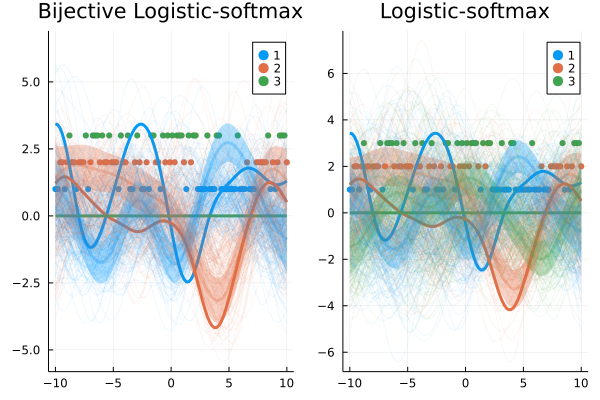

In [16]:
samples = map(liks, Ys, plts) do lik, Y, plt
    fs_init = nestedview(randn(N, nlatent(lik)))
    Ω = init_aux_variables(lik, N)
    # Run the sampling for default number of iterations (200)
    return gibbs_sample(fz, lik, Y, fs_init, Ω)
    # And visualize the samples overlapped to the variational posterior
    # that we found earlier.
end;

for i in 1:2
    for fs in samples[i]
        for j in 1:nlatent(liks[i])
            plot!(plts[i], x, fs[j]; color=j, alpha=0.07, label="")
        end
    end
end
plot(plts...)

<hr />
<h6>Package and system information</h6>
<details>
<summary>Package information (click to expand)</summary>
<pre>
      Status &#96;~/work/AugmentedGPLikelihoods.jl/AugmentedGPLikelihoods.jl/examples/categorical/Project.toml&#96;
  &#91;99985d1d&#93; AbstractGPs v0.5.13
  &#91;298c2ebc&#93; ApproximateGPs v0.4.2
  &#91;65a8f2f4&#93; ArraysOfArrays v0.5.10
  &#91;4689c64d&#93; AugmentedGPLikelihoods v0.4.15 &#96;/home/runner/work/AugmentedGPLikelihoods.jl/AugmentedGPLikelihoods.jl#f273c89&#96;
  &#91;31c24e10&#93; Distributions v0.25.62
  &#91;98b081ad&#93; Literate v2.13.4
  &#91;91a5bcdd&#93; Plots v1.30.0
  &#91;03a91e81&#93; SplitApplyCombine v1.2.1
</pre>
To reproduce this notebook's package environment, you can
<a href="./Manifest.toml">
download the full Manifest.toml</a>.
</details>
<details>
<summary>System information (click to expand)</summary>
<pre>
Julia Version 1.7.3
Commit 742b9abb4d &#40;2022-05-06 12:58 UTC&#41;
Platform Info:
  OS: Linux &#40;x86_64-pc-linux-gnu&#41;
  CPU: Intel&#40;R&#41; Xeon&#40;R&#41; Platinum 8272CL CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 &#40;ORCJIT, skylake-avx512&#41;
Environment:
  JULIA_LOAD_PATH &#61; :/home/runner/.julia/packages/JuliaGPsDocs/fsJ6N/src
</pre>
</details>

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*